原文参照：https://mmengine.readthedocs.io/zh-cn/latest/examples/train_a_gan.html

In [1]:
!pip install -U openmim
!mim install mmengine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.2 MB/s eta 0:00

因为我们没有使用GPU加速。这里只能使用Lite版本的mmcv。

In [2]:
!mim install mmcv-lite

Looking in links: https://download.openmmlab.com/mmcv/dist/cu124/torch2.5.0/index.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.3/732.3 kB 19.5 MB/s eta 0:00:00


# 构建数据加载器

## 构建数据集

接下来, 我们为 MNIST 数据集构建一个数据集类 MNISTDataset, 继承自数据集基类 BaseDataset, 并且重载数据集基类的 load_data_list 函数, 保证返回值为 list[dict]，其中每个 dict 代表一个数据样本。更多关于 MMEngine 中数据集的用法，可以参考数据集教程。

In [3]:
import numpy as np
from mmcv.transforms import to_tensor
from torch.utils.data import random_split
from torchvision.datasets import MNIST

from mmengine.dataset import BaseDataset


class MNISTDataset(BaseDataset):

    def __init__(self, data_root, pipeline, test_mode=False):
        # 下载 MNIST 数据集
        if test_mode:
            mnist_full = MNIST(data_root, train=True, download=True)
            self.mnist_dataset, _ = random_split(mnist_full, [55000, 5000])
        else:
            self.mnist_dataset = MNIST(data_root, train=False, download=True)

        super().__init__(
            data_root=data_root, pipeline=pipeline, test_mode=test_mode)

    @staticmethod
    def totensor(img):
        if len(img.shape) < 3:
            img = np.expand_dims(img, -1)
        img = np.ascontiguousarray(img.transpose(2, 0, 1))
        return to_tensor(img)

    def load_data_list(self):
        return [
            dict(inputs=self.totensor(np.array(x[0]))) for x in self.mnist_dataset
        ]


dataset = MNISTDataset("./data", [])

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 344kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.64MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



使用 Runner 中的函数 build_dataloader 来构建数据加载器。

In [4]:
import os
import torch
from mmengine.runner import Runner

NUM_WORKERS = int(os.cpu_count() / 2)
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

train_dataloader = dict(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dataset)
train_dataloader = Runner.build_dataloader(train_dataloader)

/usr/local/lib/python3.11/dist-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


# 构建生成器网络和判别器网络

下面的代码构建并实例化了一个生成器(Generator)和一个判别器(Discriminator)。

In [5]:
# 导入 PyTorch 神经网络模块 torch.nn，并将其命名为 nn。
# 这个模块包含了构建神经网络所需的各种类，例如线性层、批归一化层、激活函数等。
import torch.nn as nn

class Generator(nn.Module):
    '''
    定义了一个名为 Generator 的类，它继承自 nn.Module。
    在 PyTorch 中，所有的神经网络模块都应该继承自 nn.Module。
    这使得 Generator 类能够拥有 PyTorch 神经网络的各种功能。
    '''
    
    def __init__(self, noise_size, img_shape):
        '''
        这是 Generator 类的构造函数。当创建一个 Generator 类的实例时，这个函数会被调用。它接收两个参数：
        
        Args:
        noise_size: 生成器输入噪声向量的维度。
        img_shape: 生成器输出图像的形状，例如 (1, 28, 28) 表示单通道（灰度）、28x28 像素的图像。
        '''

        # 调用父类 nn.Module 的构造函数。
        # 这是必须的，以确保 Generator 类正确地初始化其父类的属性和方法。
        super().__init__()

        # 将传入的图像形状 img_shape 保存为 Generator 实例的一个属性。
        # 这样在 Generator 类的其他方法中就可以方便地访问图像的形状。
        self.img_shape = img_shape
        # 将传入的噪声向量维度 noise_size 保存为 Generator 实例的一个属性。
        # 这在定义生成器的网络结构时会用到。
        self.noise_size = noise_size

        def block(in_feat, out_feat, normalize=True):
            '''
            定义一个名为 block 的内部函数。
            这个函数用于创建一个包含一个线性层、一个可选的批归一化层和一个 LeakyReLU 激活层的序列。
            这个模块化的设计使得构建生成器的层变得更加简洁。

            Args:
            in_feat: 输入特征的维度。
            out_feat: 输出特征的维度。
            normalize: 一个布尔值，指示是否在线性层之后添加批归一化层，默认为 True。
            '''

            # 在 block 函数内部，首先创建一个包含一个线性层的列表。
            # nn.Linear(in_feat, out_feat) 定义了一个从 in_feat 维输入到 out_feat 维输出的全连接层。
            layers = [nn.Linear(in_feat, out_feat)]

            # 如果 normalize 为 True，则向 layers 列表中添加一个 nn.BatchNorm1d 层。
            # 批归一化层有助于加速训练并提高模型的稳定性。
            # out_feat 指定了批归一化层的输入维度，0.8 是动量（momentum）参数，用于计算移动平均和移动方差。
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))

            # 无论是否添加了批归一化层，都会向 layers 列表中添加一个 LeakyReLU 激活函数。
            # LeakyReLU 是一种非线性激活函数，有助于模型学习复杂的模式。
            # 0.2 是负斜率的系数，inplace=True 表示直接在输入上进行修改，以节省内存。
            layers.append(nn.LeakyReLU(0.2, inplace=True))

            # block 函数返回包含所创建的层的列表。
            return layers

        # 创建一个 nn.Sequential 容器，它会将接收到的模块按顺序组合成一个新的模块。
        # nn.Sequential 是 PyTorch 中一个非常有用的容器，它允许你按顺序组合多个神经网络层。输入数据会依次通过这些层。
        # 这个 self.model 就是生成器的主要网络结构。
        self.model = nn.Sequential(
            # 调用之前定义的 block 函数，创建了一个输入维度为 noise_size，输出维度为 128 的线性层，并且没有使用批归一化 (normalize=False)。
            # * 运算符用于将 block 函数返回的列表中的各个层作为 nn.Sequential 的子模块。
            *block(noise_size, 128, normalize=False),
            # 再次调用 block 函数，创建了一个输入维度为 128，输出维度为 256 的线性层，并使用了默认的批归一化 (normalize=True)。
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            # 添加一个线性层，其输入维度为 1024，输出维度为图像像素的总数。
            # np.prod(img_shape) 计算了图像形状 img_shape 中所有元素的乘积，例如对于 (1, 28, 28)，结果是 1×28×28=784。
            nn.Linear(1024, int(np.prod(img_shape))),
            # 添加一个 Tanh 激活函数。
            # Tanh 函数的输出范围在 -1 到 1 之间，通常用在生成器的最后一层，以将生成的像素值缩放到这个范围内。
            nn.Tanh(),
        )

    def forward(self, z):
        '''
        定义 Generator 类的前向传播方法 forward。
        当给生成器输入一个噪声向量时，这个方法会被调用。
        z 是输入的噪声向量。
        '''

        # 将输入的噪声向量 z 通过之前定义的 self.model 网络结构进行前向传播。
        # self.model 会按顺序执行其中包含的各个层，最终得到一个输出张量 img，这个张量表示生成的“扁平化”的图像。
        img = self.model(z)
        # 对 img 张量进行形状变换（reshape）。
        # img.size(0) 获取了批次大小（batch size），*self.img_shape 将之前保存的图像形状展开作为新的形状参数。
        # 例如，如果 img 的形状是 (batch_size, 784) 且 self.img_shape 是 (1, 28, 28)，那么 img 的形状会被变换为 (batch_size, 1, 28, 28)，即生成了一批指定形状的图像。
        img = img.view(img.size(0), *self.img_shape)
        # 返回最终生成的图像张量 img。
        return img


## 前向传播

在PyTorch中，forward函数是定义模型前向传播逻辑的核心函数。它定义了前向传播的过程，也就是输入数据经过这些层之后得到输出的过程。它的作用及调用机制如下：

1. forward函数的作用
   **前向传播逻辑**：forward函数定义了输入数据如何通过模型的各个层（如卷积层、全连接层等）逐步变换为输出。
   **不直接操作数据**：你不需要手动调用forward()，也不应直接操作输入张量的requires_grad属性，PyTorch会自动处理梯度计算。

2. forward的调用机制

    **通过__call__隐式调用**：
    当你将输入数据传递给继承自`nn.Module`的模型实例时（例如`img = model(z)`），PyTorch的`nn.Module`基类会通过其`__call__`方法自动调用`forward`函数。

    **__call__的额外操作**：
    在调用`forward`之前，`__call__`还会执行一些内部管理操作。

In [6]:
class Discriminator(nn.Module):
    '''
    定义一个名为 Discriminator 的类。
    这个类继承自 torch.nn.Module，这是在 PyTorch 中构建神经网络模型的标准做法。
    通过继承 nn.Module，Discriminator 类将拥有 PyTorch 神经网络模块的基本功能和属性。
    '''
    def __init__(self, img_shape):
        '''
        定义类的构造函数 __init__。
        每当你创建一个 Discriminator 类的实例时，这个函数会被自动调用。
        它接收一个参数 img_shape，这个参数很可能是一个包含图像维度信息的元组。
        例如，对于一个 28x28 的灰度图像，img_shape 可能是 (1, 28, 28)，或者对于一个 32x32 的 RGB 图像，可能是 (3, 32, 32)。
        '''
        super().__init__()

        # 创建一个 nn.Sequential 对象，并将其赋值给 self.model。
        self.model = nn.Sequential(
            # 定义 nn.Sequential 中的第一个神经网络层，它是一个线性层（全连接层）。
            # * np.prod(img_shape): np.prod() 是 NumPy 库中的一个函数，它计算给定数组中所有元素的乘积。
            #   在这里，img_shape （例如 (1, 28, 28)）的所有维度相乘的结果就是图像的总像素数（例如 1×28×28=784）。
            #   int() 将结果转换为整数。
            #   这个值作为 nn.Linear 的第一个参数，表示输入到这个线性层的特征数量，也就是展平后的图像像素数。
            # 512: 这是 nn.Linear 的第二个参数，表示这个线性层的输出特征数量，也就是将输入展平的图像映射到一个 512 维的向量空间。
            nn.Linear(int(np.prod(img_shape)), 512),
            # 定义 nn.Sequential 中的第二个层，它是一个 Leaky ReLU 激活函数。
            # * nn.LeakyReLU(0.2): Leaky ReLU 是一种非线性激活函数，它在输入小于零时也允许一个小的梯度通过，以解决 ReLU 函数可能出现的“死亡 ReLU”问题。
            #   这里的 0.2 是负斜率的系数。
            # * inplace=True: 这个参数表示进行原地操作，即直接修改输入的值，而不是创建一个新的输出。
            #   这可以节省内存。
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            # 定义 nn.Sequential 中的第六个层，它是一个 Sigmoid 激活函数。
            # Sigmoid 函数将输入值压缩到 0 到 1 的范围内。
            # 在判别器中，这个输出值可以被解释为输入图像是真实样本的概率，值越接近 1 表示判别器认为图像越真实，值越接近 0 表示判别器认为图像是生成的。
            nn.Sigmoid(),
        )

    def forward(self, img):
        '''
        定义 Discriminator 类的前向传播方法 forward。
        当输入数据传递给 Discriminator 实例时，这个方法会被自动调用。
        它接收一个参数 img，这通常是一个表示输入图像的 PyTorch 张量。
        '''

        # 对输入的图像张量 img 进行形状变换（reshape）。
        # * img.size(0): 这获取了 img 张量的第一个维度的大小，通常是批次大小（batch size）。
        # * -1: 这表示让 PyTorch 自动计算剩余维度的大小，以保证元素的总数不变。
        #   因此，img.view(img.size(0), -1) 的作用是将输入的图像张量展平成一个二维张量，其形状为 (batch_size, num_pixels)，其中 num_pixels 是图像的总像素数。
        img_flat = img.view(img.size(0), -1)
        # 将展平后的图像数据 img_flat 作为输入传递给 self.model，也就是之前定义的 nn.Sequential 模块。
        # 数据会依次通过 self.model 中定义的线性层和激活函数。
        # 最终的输出 validity 是一个形状为 (batch_size, 1) 的张量，其中每个元素表示对应输入图像被判别器认为是真实图像的概率。
        validity = self.model(img_flat)

        # 返回判别器的输出 validity。
        return validity


In [7]:
# 100 表明生成器将接收一个长度为 100 的随机数数组作为输入。
# 它是生成新图像的种子或潜在空间。
# noise_size 定义了输入到生成器网络的随机噪声向量的维度。
# 可以将这个 100 维的噪声向量想象成编码了生成图像的各种潜在特征。
# 虽然我们人类很难直接理解这 100 个维度分别代表什么，但网络在训练过程中会学习如何将这些维度组合起来，控制生成图像的高级属性，比如图像的整体风格、某些物体的形状、颜色等等。
# 可以把它想象成这样：
#    你有一个包含 100 个旋钮的魔法盒子（噪声向量）。
#    每个旋钮控制着图像的不同方面（潜在特征）。
#    生成器网络就像一个复杂的机器，它知道如何调整这 100 个旋钮，最终组合成一幅完整的图像。
#    每次你随机设置这 100 个旋钮的值，魔法盒子就会产生一张新的图像。

# (1, 28, 28) 表明生成器的目标是生成形状为单通道（灰度）、28x28 像素的图像。
generator = Generator(100, (1, 28, 28))

# 在创建实例的过程中，它通过传递 (1, 28, 28) 这个元组，告诉判别器的 __init__ 方法，这个判别器将要处理的图像的形状是 1 通道、28x28 像素的。
discriminator = Discriminator((1, 28, 28))

# 构建一个生成对抗网络模型

在使用 MMEngine 时，我们用 [ImgDataPreprocessor](https://mmengine.readthedocs.io/zh-cn/latest/api/generated/mmengine.model.ImgDataPreprocessor.html#mmengine.model.ImgDataPreprocessor) 来对数据进行归一化和颜色通道的转换。

## ImgDataPreprocessor

MMEngine提供的一个用于归一化和 bgr 转 rgb 转换的图像预处理程序。

接收数据加载器采样的数据，并将其预处理为模型输入格式。 ImgDataPreprocessor 提供以下基本数据预处理：

* 将数据收集并移动到目标设备。
* 如果输入形状为（3，H，W），则将输入从 bgr 转换为 rgb。
* 使用定义的均值和标准差对图像进行归一化。
* 使用定义的 pad_value 将输入填充到当前批次的最大尺寸。填充大小可以是定义的 pad_size_divisor 的倍数。
* 将输入堆叠到 batch_inputs 中。

对于 ImgDataPreprocessor ，单个输入的维度必须是 (3, H, W)。

In [8]:
from mmengine.model import ImgDataPreprocessor

data_preprocessor = ImgDataPreprocessor(mean=([127.5]), std=([127.5]))

### 127.5

对于将像素值从 [0,255] 范围标准化到 [−1,1] 范围，通常会进行以下操作：

* 中心化 (Centering): 从每个像素值中减去一个均值。
* 缩放 (Scaling): 将结果除以一个标准差或者一个固定的范围值。

上面例子中，默认值 127.5 很可能被用作中心化的均值，并且假设像素值的原始范围是 [0,255]。如果目标范围是 [−1,1]，那么缩放因子很可能是 127.5。

## 基础 GAN 算法

下面的代码实现了基础 GAN 的算法。使用 MMEngine 实现算法类，需要继承 [BaseModel](https://mmengine.readthedocs.io/zh-cn/latest/api/generated/mmengine.model.BaseModel.html#mmengine.model.BaseModel) 基类，在 train_step 中实现训练过程。GAN 需要交替训练生成器和判别器，分别由 train_discriminator 和 train_generator 实现，并实现 disc_loss 和 gen_loss 计算判别器损失函数和生成器损失函数。 关于 BaseModel 的更多信息，请参考[模型教程](https://mmengine.readthedocs.io/zh-cn/latest/tutorials/model.html).

In [9]:
import torch.nn.functional as F
from mmengine.model import BaseModel

class GAN(BaseModel):

    def __init__(self, generator, discriminator, noise_size,
                 data_preprocessor):
        super().__init__(data_preprocessor=data_preprocessor)
        assert generator.noise_size == noise_size
        self.generator = generator
        self.discriminator = discriminator
        self.noise_size = noise_size

    def train_step(self, data, optim_wrapper):
        '''
        实现默认模型训练过程，包括预处理、模型前向传播、损失计算、优化和反向传播。

        Args:
        data: 从数据集中采样的数据。即下文中传入 Runner 的 train_dataloader 。
        optim_wrapper: 是用于更新模型参数的 OptimWrapper 实例。详见后续的“优化器”的章节
        '''
        
        # 获取数据和数据预处理
        # 如果忘记了，这是上一节中的 ImgDataPreprocessor
        inputs_dict = self.data_preprocessor(data, True)
        
        # 训练判别器
        disc_optimizer_wrapper = optim_wrapper['discriminator']
        with disc_optimizer_wrapper.optim_context(self.discriminator):
            log_vars = self.train_discriminator(inputs_dict,
                                                disc_optimizer_wrapper)

        # 训练生成器
        ## 训练生成器时冻结判别器
        ## 避免梯度冗余计算：生成器的训练仅需反向传播到自身参数，无需更新判别器。关闭判别器梯度可减少计算量和内存占用。
        ## 稳定对抗训练：防止判别器在生成器训练时被意外更新，确保二者交替优化。生成器的目标是“欺骗”当前固定的判别器，而非适配一个动态变化的判别器。
        set_requires_grad(self.discriminator, False)
        gen_optimizer_wrapper = optim_wrapper['generator']
        with gen_optimizer_wrapper.optim_context(self.generator):
            log_vars_gen = self.train_generator(inputs_dict,
                                                gen_optimizer_wrapper)

        ## 恢复判别器梯度以训练判别器
        set_requires_grad(self.discriminator, True)
        log_vars.update(log_vars_gen)

        return log_vars

    def forward(self, batch_inputs, data_samples=None, mode=None):
        return self.generator(batch_inputs)

    # 用于 discriminator 的损失函数
    def disc_loss(self, disc_pred_fake, disc_pred_real):
        losses_dict = dict()
        # 判别器对生成样本的预测值（期望接近0）
        ## 等同于 torch.zeros_like(disc_pred_fake)
        losses_dict['loss_disc_fake'] = F.binary_cross_entropy(
            disc_pred_fake, 0. * torch.ones_like(disc_pred_fake))
        # 判别器对真实样本的预测值（期望接近1）。
        losses_dict['loss_disc_real'] = F.binary_cross_entropy(
            disc_pred_real, 1. * torch.ones_like(disc_pred_real))

        loss, log_var = self.parse_losses(losses_dict)
        return loss, log_var

    # 用于 generator 的损失函数
    def gen_loss(self, disc_pred_fake):
        losses_dict = dict()
        losses_dict['loss_gen'] = F.binary_cross_entropy(
            disc_pred_fake, 1. * torch.ones_like(disc_pred_fake))
        loss, log_var = self.parse_losses(losses_dict)
        return loss, log_var

    def train_discriminator(self, inputs, optimizer_wrapper):
        real_imgs = inputs['inputs']
        z = torch.randn(
            (real_imgs.shape[0], self.noise_size)).type_as(real_imgs)
        with torch.no_grad():
            fake_imgs = self.generator(z)

        disc_pred_fake = self.discriminator(fake_imgs)
        disc_pred_real = self.discriminator(real_imgs)

        parsed_losses, log_vars = self.disc_loss(disc_pred_fake,
                                                 disc_pred_real)
        optimizer_wrapper.update_params(parsed_losses)
        return log_vars

    def train_generator(self, inputs, optimizer_wrapper):
        real_imgs = inputs['inputs']
        z = torch.randn(real_imgs.shape[0], self.noise_size).type_as(real_imgs)

        fake_imgs = self.generator(z)

        disc_pred_fake = self.discriminator(fake_imgs)
        parsed_loss, log_vars = self.gen_loss(disc_pred_fake)

        optimizer_wrapper.update_params(parsed_loss)
        return log_vars

# 函数 set_requires_grad 用来锁定训练生成器时判别器的权重。
# 通过控制梯度计算来优化训练过程。
def set_requires_grad(nets, requires_grad=False):
    """Set requires_grad for all the networks.

    Args:
        nets (nn.Module | list[nn.Module]): A list of networks or a single
            network.
        requires_grad (bool): Whether the networks require gradients or not.
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad


In [10]:
model = GAN(generator, discriminator, 100, data_preprocessor)

# 构建优化器

MMEngine 使用 [OptimWrapper](https://mmengine.readthedocs.io/zh-cn/latest/api/generated/mmengine.optim.OptimWrapper.html#mmengine.optim.OptimWrapper) 来封装优化器，对于多个优化器的情况，使用 [OptimWrapperDict](https://mmengine.readthedocs.io/zh-cn/latest/api/generated/mmengine.optim.OptimWrapperDict.html#mmengine.optim.OptimWrapperDict) 对 OptimWrapper 再进行一次封装。 关于优化器的更多信息，请参考[优化器教程](https://mmengine.readthedocs.io/zh-cn/latest/tutorials/optim_wrapper.html).

在GAN的训练中，优化器（Optimizer）的作用是通过梯度下降算法更新生成器（Generator）和判别器（Discriminator）的模型参数，使它们朝着最小化各自损失函数的方向优化。

GAN的训练本质是参数优化问题

GAN的生成器和判别器是两个独立的神经网络，它们的参数需要通过反向传播和梯度下降来更新：

* 生成器的目标：生成尽可能逼真的样本，让判别器无法区分真假。
* 判别器的目标：准确区分真实样本和生成样本。
* 优化器的作用：根据损失函数计算的梯度，调整模型参数以逐步逼近目标。

Adam（Adaptive Moment Estimation）是一种基于梯度下降的优化算法，可以看作是传统随机梯度下降（SGD）的增强版本。

In [11]:
from mmengine.optim import OptimWrapper, OptimWrapperDict

opt_g = torch.optim.Adam(
    generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_g_wrapper = OptimWrapper(opt_g)

opt_d = torch.optim.Adam(
    discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
opt_d_wrapper = OptimWrapper(opt_d)

opt_wrapper_dict = OptimWrapperDict(
    generator=opt_g_wrapper, discriminator=opt_d_wrapper)


# 使用执行器进行训练

下面的代码演示了如何使用 Runner 进行模型训练。关于 [Runner](https://mmengine.readthedocs.io/zh-cn/latest/api/generated/mmengine.runner.Runner.html#mmengine.runner.Runner) 的更多信息，请参考[执行器教程](https://mmengine.readthedocs.io/zh-cn/latest/tutorials/runner.html)。

In [12]:
train_cfg = dict(by_epoch=True, max_epochs=220)
runner = Runner(
    model,
    work_dir='runs/gan/',
    train_dataloader=train_dataloader,
    train_cfg=train_cfg,
    # 计算模型参数的梯度。与 train_dataloader 配合使用。
    optim_wrapper=opt_wrapper_dict)
runner.train()

04/22 05:31:47 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
    CUDA available: False
    MUSA available: False
    numpy_random_seed: 166047967
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.5.1+cu124
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2025.1-Product Build 20250306 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.4, CUDNN_VERSION=9.1.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-v

GAN(
  (data_preprocessor): ImgDataPreprocessor()
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Linear(in_features=256, out_features=512, bias=True)
      (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Linear(in_features=512, out_features=1024, bias=True)
      (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Linear(in_features=1024, out_features=784, bias=True)
      (12): Tanh()
    )
  )
  (discriminator): Discriminator(
    (model): Sequenti

到这里，我们就完成了一个 GAN 的训练，通过下面的代码可以查看刚才训练的 GAN 生成的结果。

In [13]:
z = torch.randn(64, 100)
img = model(z)

from torchvision.utils import save_image
save_image(img, "result.png", normalize=True)

动态显示生成结果的图像数据: 使用 matplotlib 和 PIL 库。

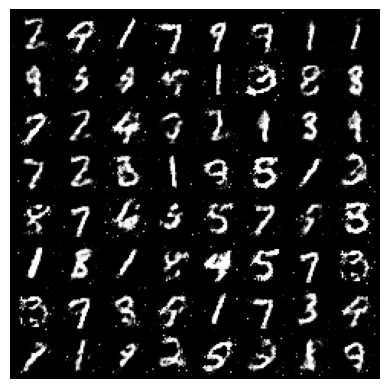

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# 打开图片
img = Image.open('result.png') # 替换为你的图片路径

# 显示图片 (需要转换为 matplotlib 可识别的格式)
plt.imshow(img)
plt.axis('off') # 关闭坐标轴 (可选)
plt.show()